## Final Project for COSC-E4 (Machine Learning) AY 2021-2022
### **Metabolic Syndrome Prediction Model with Catboost classifier**

We built a model that can be used for predicting whether the person has a metabolic syndrome or not, based on common risk factors. In this model we created, we have achieved an accuracy mean of **89.47%**, which is shown below.

### **Dataset Description**

The dataset for analysis came from Centers for Disease Control and Prevention of USA. National Health and Nutrition Examination Survey **(NHANES)**

In [2]:
# Import all needed library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
# import matplotlib.pyplot as plt # for data visualization purposes
# import seaborn as sns # for statistical data visualization
import optuna
from optuna.samplers import TPESampler
pd.pandas.set_option('display.max_columns',None)


In [3]:
data = 'Metabolic_Syndrome.csv'
df = pd.read_csv(data, index_col= 0)

In [4]:
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


Now we determine **CATEGORICAL** and **NUMERICAL** variables, that will be used for predictions.

In [7]:
categorical = [var for var in df.columns if df[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 4 categorical variables

The categorical variables are :

 ['Sex', 'Marital', 'Race', 'MetabolicSyndrome']


In [8]:
print('Frequency counts of values in Categorical Variables')
for var in categorical: 
    
    print(df[var].value_counts())

Frequency counts of values in Categorical Variables
Female    1211
Male      1190
Name: Sex, dtype: int64
Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64
No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64


In [10]:

print('Frequency distribution of Categorical Variables')
for var in categorical: 
    
    print(df[var].value_counts()/float(len(df)))


Frequency distribution of Categorical Variables
Female    0.504373
Male      0.495627
Name: Sex, dtype: float64
Married      0.496460
Single       0.207414
Divorced     0.100791
Widowed      0.069138
Separated    0.039567
Name: Marital, dtype: float64
White          0.388588
Black          0.228238
Asian          0.145356
Hispanic       0.107039
MexAmerican    0.105373
Other          0.025406
Name: Race, dtype: float64
No MetSyn    0.657643
MetSyn       0.342357
Name: MetabolicSyndrome, dtype: float64


In [9]:
#Cleaning the SEX attribute, determining whether the it has null values or not.
df.Sex.unique()
df.Sex.value_counts()

Female    1211
Male      1190
Name: Sex, dtype: int64

In [11]:
# Replacing all ? values
df['Sex'].replace('?', np.NaN, inplace=True)

In [12]:
df.Sex.value_counts()

Female    1211
Male      1190
Name: Sex, dtype: int64

In [10]:
#Cleaning the MARITAL attribute, determining whether the it has null values or not.
df.Marital.unique()
df.Marital.value_counts()


Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [11]:
df['Marital'].replace('?', np.NaN, inplace=True)

In [12]:
df.Marital.value_counts()

Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64

In [13]:
#Cleaning the RACE attribute, determining whether the it has null values or not.
df.Race.unique()
df.Race.value_counts()


White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64

In [14]:
df['Race'].replace('?', np.NaN, inplace=True)

In [15]:
df.Race.value_counts()

White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64

In [13]:
#Cleaning the METABOLICSYNDROME attribute, determining whether the it has null values or not.
df.MetabolicSyndrome.unique()
df.MetabolicSyndrome.value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [15]:
df['MetabolicSyndrome'].replace('?', np.NaN, inplace=True)

In [16]:
df.MetabolicSyndrome.value_counts()

No MetSyn    1579
MetSyn        822
Name: MetabolicSyndrome, dtype: int64

In [17]:
df[categorical].isnull().sum()


Sex                    0
Marital              208
Race                   0
MetabolicSyndrome      0
dtype: int64

In [18]:
for var in categorical:
    
    print(var, ' contains ', len(df[var].unique()), ' labels')

Sex  contains  2  labels
Marital  contains  6  labels
Race  contains  6  labels
MetabolicSyndrome  contains  2  labels


In [19]:
# find numerical variables

numerical = [var for var in df.columns if df[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :', numerical)

There are 10 numerical variables

The numerical variables are : ['Age', 'Income', 'WaistCirc', 'BMI', 'Albuminuria', 'UrAlbCr', 'UricAcid', 'BloodGlucose', 'HDL', 'Triglycerides']


In [20]:
df[numerical].head()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
seqn,,,,,,,,,,
62161,22,8200.0,81.0,23.3,0,3.88,4.9,92,41,84
62164,44,4500.0,80.1,23.2,0,8.55,4.5,82,28,56
62169,21,800.0,69.6,20.1,0,5.07,5.4,107,43,78
62172,43,2000.0,120.4,33.3,0,5.22,5.0,104,73,141
62177,51,NaN,81.1,20.1,0,8.13,5.0,95,43,126


In [21]:
df[numerical].isnull().sum()


Age                0
Income           117
WaistCirc         85
BMI               26
Albuminuria        0
UrAlbCr            0
UricAcid           0
BloodGlucose       0
HDL                0
Triglycerides      0
dtype: int64

In [22]:
df['Income'] = df['Income'].replace(np.nan, 0)
df['WaistCirc'] = df['WaistCirc'].replace(np.nan, 0)
df['BMI'] = df['BMI'].replace(np.nan, 0)
df[numerical].isnull().sum()

Age              0
Income           0
WaistCirc        0
BMI              0
Albuminuria      0
UrAlbCr          0
UricAcid         0
BloodGlucose     0
HDL              0
Triglycerides    0
dtype: int64

In [23]:
# Separate columns by data type for analysis
#numerical = [var for var in df.columns if df[var].dtype!='O']
#categorical = [var for var in df.columns if df[var].dtype=='O']

cat_cols = [var for var in df.columns if df[var].dtype=='O']
num_cols = [var for var in df.columns if df[var].dtype!='O']
assert len(cat_cols) + len(num_cols) == df.shape[1]

In [24]:
cat_cols.remove('MetabolicSyndrome')
print(cat_cols)

['Sex', 'Marital', 'Race']


In [25]:
from sklearn.model_selection import train_test_split
X, y = df.dropna().drop(['MetabolicSyndrome'], axis=1), df.dropna()['MetabolicSyndrome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =13)
X_train.shape, X_test.shape
X_train.head()


,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides
seqn,,,,,,,,,,,,,
63236,80,Male,Divorced,1000.0,Hispanic,105.0,29.4,2,355.56,6.0,116,43,115
69343,20,Male,Single,9000.0,White,95.1,27.2,0,4.26,5.2,111,39,239
64789,67,Male,Married,9000.0,Black,120.3,30.9,0,3.38,7.0,127,52,94
66690,65,Male,Married,1600.0,MexAmerican,109.8,30.9,0,4.36,5.3,102,43,93
68065,20,Female,Single,1000.0,White,82.5,25.3,0,5.93,4.5,92,41,128


In [26]:
# Specify index of categorical features in input data
cat_features = [X.columns.get_loc(col) for col in cat_cols]

# Model parameter dict
params = {'iterations':5000,
          'loss_function':'Logloss',
          'depth':4,
          'early_stopping_rounds':20,
          'custom_loss':['AUC', 'Accuracy']}

# Instantiate model
model = CatBoostClassifier(**params)

# Fit model
model.fit(
    X_train,
    y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=50,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.018077
0:	learn: 0.6755342	test: 0.6763908	best: 0.6763908 (0)	total: 193ms	remaining: 16m 6s
50:	learn: 0.3248273	test: 0.3520611	best: 0.3520611 (50)	total: 1.34s	remaining: 2m 10s
100:	learn: 0.2610080	test: 0.3019089	best: 0.3019089 (100)	total: 2.4s	remaining: 1m 56s
150:	learn: 0.2298860	test: 0.2802603	best: 0.2802603 (150)	total: 3.62s	remaining: 1m 56s
200:	learn: 0.2150166	test: 0.2732349	best: 0.2732349 (200)	total: 4.86s	remaining: 1m 56s
250:	learn: 0.2039187	test: 0.2687043	best: 0.2687043 (250)	total: 6s	remaining: 1m 53s
300:	learn: 0.1949248	test: 0.2646383	best: 0.2644539 (297)	total: 7.21s	remaining: 1m 52s
350:	learn: 0.1864380	test: 0.2610587	best: 0.2610587 (350)	total: 8.41s	remaining: 1m 51s
400:	learn: 0.1788643	test: 0.2596967	best: 0.2596967 (400)	total: 9.6s	remaining: 1m 50s
450:	learn: 0.1706461	test: 0.2567549	best: 0.2566582 (435)	total: 10.9s	remaining: 1m 49s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.255

In [27]:
# Make predictions on test data
preds = model.predict(X_test)

In [28]:
# Evaluate predictions
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

      MetSyn       0.85      0.79      0.82       163
   No MetSyn       0.88      0.92      0.90       276

    accuracy                           0.87       439
   macro avg       0.87      0.85      0.86       439
weighted avg       0.87      0.87      0.87       439

[[129  34]
 [ 23 253]]


<AxesSubplot:xlabel='importance', ylabel='feature'>

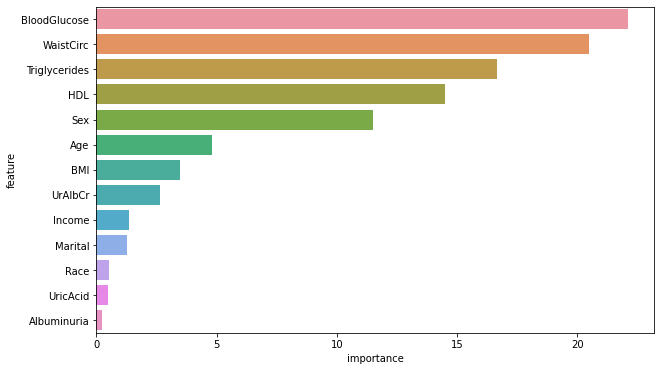

In [31]:
# Showing the most important features for predicting Metabolic Syndrome.

fig,ax = plt.subplots(figsize=(10,6))
feature_importance_data = pd.DataFrame({'feature':model.feature_names_, 'importance':model.feature_importances_})
feature_importance_data.sort_values('importance', ascending=False, inplace=True)
sns.barplot(x='importance', y='feature', data=feature_importance_data)

In [32]:
def classification_objective(trial):

    params = {
        "loss_function":"Logloss",
        'custom_loss':['Accuracy'],
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20)}
    
    if params["bootstrap_type"] == "Bayesian":
        
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    elif params["bootstrap_type"] == "Bernoulli":
        
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=False)
    
    return cv_data['test-Accuracy-mean'].values[-1]


In [41]:
classification_study = optuna.create_study(sampler=TPESampler(), direction="maximize")
classification_study.optimize(classification_objective, n_trials=20, timeout=600) 
trial = classification_study.best_trial

print(f"Highest Accuracy: {trial.value}")
print("Optimal Parameters:")
for key, val in trial.params.items():
    print(f"{key}:{val}")

[I 2022-07-10 17:14:13,564] A new study created in memory with name: no-name-499728e0-9347-49b3-ba66-c41ed985f92b


Training on fold [0/5]

bestTest = 0.218695289
bestIteration = 963

Training on fold [1/5]

bestTest = 0.2027781405
bestIteration = 818

Training on fold [2/5]

bestTest = 0.2083035523
bestIteration = 902

Training on fold [3/5]

bestTest = 0.2479399651
bestIteration = 617

Training on fold [4/5]

bestTest = 0.2105445264
bestIteration = 779



[I 2022-07-10 17:14:23,285] Trial 0 finished with value: 0.8928417636596249 and parameters: {'l2_leaf_reg': 0.09687128529805306, 'colsample_bylevel': 0.3531859285185264, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 19, 'subsample': 0.9176985840319015}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2175649867
bestIteration = 199

Training on fold [1/5]

bestTest = 0.2037524921
bestIteration = 304

Training on fold [2/5]

bestTest = 0.2045397196
bestIteration = 435

Training on fold [3/5]

bestTest = 0.2522503075
bestIteration = 128

Training on fold [4/5]


[I 2022-07-10 17:14:43,679] Trial 1 finished with value: 0.8891939963179081 and parameters: {'l2_leaf_reg': 0.15079708766887476, 'colsample_bylevel': 0.953235814554415, 'depth': 6, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 2, 'one_hot_max_size': 14}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2135097206
bestIteration = 284

Training on fold [0/5]

bestTest = 0.2567964402
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2426405164
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2606648241
bestIteration = 998

Training on fold [3/5]

bestTest = 0.2767242905
bestIteration = 912

Training on fold [4/5]

bestTest = 0.2580692505
bestIteration = 988



[I 2022-07-10 17:14:50,286] Trial 2 finished with value: 0.8773312114498497 and parameters: {'l2_leaf_reg': 0.6510124958148155, 'colsample_bylevel': 0.10641018814363952, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 7, 'subsample': 0.32605933549435373}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2299133238
bestIteration = 154

Training on fold [1/5]

bestTest = 0.2098068556
bestIteration = 206

Training on fold [2/5]

bestTest = 0.2193183356
bestIteration = 299

Training on fold [3/5]

bestTest = 0.2559081392
bestIteration = 176

Training on fold [4/5]


[I 2022-07-10 17:15:35,017] Trial 3 finished with value: 0.8882786740308506 and parameters: {'l2_leaf_reg': 0.43492818097362645, 'colsample_bylevel': 0.4666223967007425, 'depth': 8, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 3, 'one_hot_max_size': 12, 'subsample': 0.8453009488701657}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2152282119
bestIteration = 200

Training on fold [0/5]

bestTest = 0.2984093892
bestIteration = 550

Training on fold [1/5]

bestTest = 0.2736476095
bestIteration = 734

Training on fold [2/5]

bestTest = 0.2875619427
bestIteration = 738

Training on fold [3/5]

bestTest = 0.3034170431
bestIteration = 232

Training on fold [4/5]


[I 2022-07-10 17:16:35,464] Trial 4 finished with value: 0.8663889495636617 and parameters: {'l2_leaf_reg': 0.1666868564924356, 'colsample_bylevel': 0.26540980504889305, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 8, 'one_hot_max_size': 17, 'bagging_temperature': 9.530323654055499}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2846857119
bestIteration = 606

Training on fold [0/5]

bestTest = 0.2332609964
bestIteration = 268

Training on fold [1/5]

bestTest = 0.2152904902
bestIteration = 391

Training on fold [2/5]

bestTest = 0.2159170186
bestIteration = 574

Training on fold [3/5]

bestTest = 0.255395052
bestIteration = 193

Training on fold [4/5]


[I 2022-07-10 17:17:00,421] Trial 5 finished with value: 0.8896474969055866 and parameters: {'l2_leaf_reg': 0.8643638945226458, 'colsample_bylevel': 0.38214196910651865, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'one_hot_max_size': 18, 'subsample': 0.6563700966484135}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2205725145
bestIteration = 574

Training on fold [0/5]

bestTest = 0.2839419334
bestIteration = 112

Training on fold [1/5]

bestTest = 0.273019132
bestIteration = 92

Training on fold [2/5]

bestTest = 0.2781783502
bestIteration = 154

Training on fold [3/5]

bestTest = 0.3048124466
bestIteration = 77

Training on fold [4/5]


[I 2022-07-10 17:17:57,148] Trial 6 finished with value: 0.8736865645250205 and parameters: {'l2_leaf_reg': 0.4792022711895028, 'colsample_bylevel': 0.438446706013852, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 12, 'one_hot_max_size': 16, 'bagging_temperature': 6.6677485002321415}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2761125837
bestIteration = 114

Training on fold [0/5]

bestTest = 0.2200880969
bestIteration = 480

Training on fold [1/5]

bestTest = 0.1928882823
bestIteration = 415

Training on fold [2/5]

bestTest = 0.2149760304
bestIteration = 690

Training on fold [3/5]

bestTest = 0.2525619751
bestIteration = 211

Training on fold [4/5]


[I 2022-07-10 17:20:23,567] Trial 7 finished with value: 0.8869056906002643 and parameters: {'l2_leaf_reg': 0.31027450471120316, 'colsample_bylevel': 0.5472602141095148, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 13, 'one_hot_max_size': 15}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2191304736
bestIteration = 296

Training on fold [0/5]

bestTest = 0.3154550625
bestIteration = 999

Training on fold [1/5]

bestTest = 0.3003297254
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3305091125
bestIteration = 999

Training on fold [3/5]

bestTest = 0.324886118
bestIteration = 983

Training on fold [4/5]

bestTest = 0.310553374
bestIteration = 999



[I 2022-07-10 17:20:33,675] Trial 8 finished with value: 0.8650190865499632 and parameters: {'l2_leaf_reg': 0.23306985895449484, 'colsample_bylevel': 0.02992591043175325, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 8, 'one_hot_max_size': 2, 'subsample': 0.11923558813517499}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2302156711
bestIteration = 374

Training on fold [1/5]

bestTest = 0.1928164329
bestIteration = 671

Training on fold [2/5]

bestTest = 0.2208152248
bestIteration = 983

Training on fold [3/5]

bestTest = 0.253470336
bestIteration = 291

Training on fold [4/5]


[I 2022-07-10 17:21:06,552] Trial 9 finished with value: 0.8923778616823206 and parameters: {'l2_leaf_reg': 0.010883227880699153, 'colsample_bylevel': 0.7468708825733583, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 15, 'subsample': 0.8114924472341961}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2220373364
bestIteration = 573

Training on fold [0/5]

bestTest = 0.2181270933
bestIteration = 995

Training on fold [1/5]

bestTest = 0.2112321044
bestIteration = 916

Training on fold [2/5]

bestTest = 0.2167916537
bestIteration = 990

Training on fold [3/5]

bestTest = 0.2502214278
bestIteration = 886

Training on fold [4/5]

bestTest = 0.2191995742
bestIteration = 977



[I 2022-07-10 17:21:14,262] Trial 10 finished with value: 0.8905565783588687 and parameters: {'l2_leaf_reg': 0.04500603880329277, 'colsample_bylevel': 0.6603649788283947, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 18, 'one_hot_max_size': 20, 'bagging_temperature': 0.4510334501956512}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2299754074
bestIteration = 922

Training on fold [1/5]

bestTest = 0.1959121
bestIteration = 885

Training on fold [2/5]

bestTest = 0.2204816337
bestIteration = 415

Training on fold [3/5]

bestTest = 0.2482426176
bestIteration = 339

Training on fold [4/5]


[I 2022-07-10 17:21:44,392] Trial 11 finished with value: 0.8859903683132065 and parameters: {'l2_leaf_reg': 0.013303198776145251, 'colsample_bylevel': 0.7691794457599939, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 10, 'subsample': 0.9801897936067219}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2384322037
bestIteration = 338

Training on fold [0/5]

bestTest = 0.2321046873
bestIteration = 672

Training on fold [1/5]

bestTest = 0.2011802731
bestIteration = 935

Training on fold [2/5]

bestTest = 0.2097133071
bestIteration = 964

Training on fold [3/5]

bestTest = 0.2458028525
bestIteration = 314

Training on fold [4/5]


[I 2022-07-10 17:22:13,381] Trial 12 finished with value: 0.8841711652676796 and parameters: {'l2_leaf_reg': 0.05157852826669076, 'colsample_bylevel': 0.8199736281479689, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 16, 'one_hot_max_size': 20, 'subsample': 0.733708242446821}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2262401752
bestIteration = 487

Training on fold [0/5]

bestTest = 0.2530696031
bestIteration = 992

Training on fold [1/5]

bestTest = 0.2417979167
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2582836034
bestIteration = 996

Training on fold [3/5]

bestTest = 0.2855180098
bestIteration = 983

Training on fold [4/5]

bestTest = 0.2559529962
bestIteration = 979



[I 2022-07-10 17:22:26,653] Trial 13 finished with value: 0.8745894051445273 and parameters: {'l2_leaf_reg': 0.010665772736823313, 'colsample_bylevel': 0.23478973201883946, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 12, 'subsample': 0.9274819733364559}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2314439584
bestIteration = 992

Training on fold [1/5]

bestTest = 0.2050566626
bestIteration = 975

Training on fold [2/5]

bestTest = 0.2218713364
bestIteration = 968

Training on fold [3/5]

bestTest = 0.2581159965
bestIteration = 550

Training on fold [4/5]


[I 2022-07-10 17:22:47,439] Trial 14 finished with value: 0.8910163197803225 and parameters: {'l2_leaf_reg': 0.026170958320074354, 'colsample_bylevel': 0.6125990009390847, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 8, 'subsample': 0.5334330183237629}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2213328287
bestIteration = 979

Training on fold [0/5]

bestTest = 0.2248323082
bestIteration = 486

Training on fold [1/5]

bestTest = 0.1922190228
bestIteration = 483

Training on fold [2/5]

bestTest = 0.2154425043
bestIteration = 575

Training on fold [3/5]

bestTest = 0.2501289319
bestIteration = 192

Training on fold [4/5]


[I 2022-07-10 17:23:17,642] Trial 15 finished with value: 0.8818880602448488 and parameters: {'l2_leaf_reg': 0.07161468037200996, 'colsample_bylevel': 0.9746817449955733, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 15, 'one_hot_max_size': 18}. Best is trial 0 with value: 0.8928417636596249.



bestTest = 0.2272419492
bestIteration = 366

Training on fold [0/5]

bestTest = 0.2179795744
bestIteration = 865

Training on fold [1/5]

bestTest = 0.206644959
bestIteration = 789

Training on fold [2/5]

bestTest = 0.2040012418
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2432554374
bestIteration = 574

Training on fold [4/5]

bestTest = 0.2105775806
bestIteration = 886



[I 2022-07-10 17:23:25,930] Trial 16 finished with value: 0.8928407235206623 and parameters: {'l2_leaf_reg': 0.023985267647549956, 'colsample_bylevel': 0.7366160564651689, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 6, 'one_hot_max_size': 14, 'subsample': 0.8005597455817515}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2547603238
bestIteration = 997

Training on fold [1/5]

bestTest = 0.2458779536
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2635807695
bestIteration = 995

Training on fold [3/5]

bestTest = 0.2853896595
bestIteration = 986

Training on fold [4/5]

bestTest = 0.2585428447
bestIteration = 880



[I 2022-07-10 17:23:39,168] Trial 17 finished with value: 0.8736761631353949 and parameters: {'l2_leaf_reg': 0.025360555199885167, 'colsample_bylevel': 0.3206951285969579, 'depth': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 4, 'one_hot_max_size': 4, 'subsample': 0.5824397515639528}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2168368499
bestIteration = 960

Training on fold [1/5]

bestTest = 0.207877985
bestIteration = 967

Training on fold [2/5]

bestTest = 0.2088748554
bestIteration = 982

Training on fold [3/5]

bestTest = 0.2609556168
bestIteration = 889

Training on fold [4/5]

bestTest = 0.216975145
bestIteration = 985



[I 2022-07-10 17:23:46,800] Trial 18 finished with value: 0.8919212406777547 and parameters: {'l2_leaf_reg': 0.10482455347914076, 'colsample_bylevel': 0.16701759373927083, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 13}. Best is trial 0 with value: 0.8928417636596249.


Training on fold [0/5]

bestTest = 0.2099463268
bestIteration = 753

Training on fold [1/5]

bestTest = 0.2028725191
bestIteration = 783

Training on fold [2/5]

bestTest = 0.2023802787
bestIteration = 914

Training on fold [3/5]

bestTest = 0.2394223868
bestIteration = 465

Training on fold [4/5]

bestTest = 0.2099602264
bestIteration = 586



[I 2022-07-10 17:23:55,347] Trial 19 finished with value: 0.8946588864272267 and parameters: {'l2_leaf_reg': 0.02749341416711339, 'colsample_bylevel': 0.8493028982345194, 'depth': 3, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 6, 'one_hot_max_size': 19, 'bagging_temperature': 0.08411757657072627}. Best is trial 19 with value: 0.8946588864272267.


Highest Accuracy: 0.8946588864272267
Optimal Parameters:
l2_leaf_reg:0.02749341416711339
colsample_bylevel:0.8493028982345194
depth:3
boosting_type:Plain
bootstrap_type:Bayesian
min_data_in_leaf:6
one_hot_max_size:19
bagging_temperature:0.08411757657072627


In [43]:
trial.params


{'l2_leaf_reg': 0.02749341416711339,
 'colsample_bylevel': 0.8493028982345194,
 'depth': 3,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'min_data_in_leaf': 6,
 'one_hot_max_size': 19,
 'bagging_temperature': 0.08411757657072627}

In [44]:
new_params = trial.params.copy()
new_params['loss_function'] = 'Logloss'
new_params['custom_loss'] = ['AUC','Accuracy']

cv_data = cv(
        params = new_params,
        pool = Pool(X, label=y, cat_features=cat_features),
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        plot=False,
        stratified=False,
        verbose=False)

cv_data

Training on fold [0/5]

bestTest = 0.2099463268
bestIteration = 753

Training on fold [1/5]

bestTest = 0.2028725191
bestIteration = 783

Training on fold [2/5]

bestTest = 0.2023802787
bestIteration = 914

Training on fold [3/5]

bestTest = 0.2394223868
bestIteration = 465

Training on fold [4/5]

bestTest = 0.2099602264
bestIteration = 586



,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std
0,0,0.660361,0.005228,0.659457,0.005290,0.908143,0.016186,0.856358,0.014193,0.858983,0.002465
1,1,0.631844,0.008669,0.630448,0.008662,0.913694,0.017181,0.852246,0.017362,0.858071,0.002993
2,2,0.612234,0.008228,0.610139,0.008205,0.916149,0.012277,0.854532,0.015466,0.860123,0.002522
3,3,0.594593,0.011530,0.592046,0.011276,0.919862,0.010084,0.852246,0.014141,0.858072,0.007284
4,4,0.575437,0.009544,0.572665,0.008830,0.922711,0.011076,0.860008,0.011136,0.861378,0.004267
...,...,...,...,...,...,...,...,...,...,...,...
995,995,0.219028,0.019750,0.092824,0.001951,0.966795,0.006107,0.895116,0.012027,0.988144,0.002890
996,996,0.219097,0.019723,0.092758,0.001963,0.966777,0.006119,0.895116,0.012027,0.988144,0.002890
997,997,0.219188,0.019752,0.092682,0.001960,0.966777,0.006116,0.894660,0.012065,0.988030,0.002674
998,998,0.219173,0.019791,0.092594,0.001966,0.966786,0.006178,0.894660,0.012065,0.988258,0.002504


In [45]:
final_params = new_params.copy()
final_params['iterations'] = np.argmax(cv_data['test-Accuracy-mean'])
final_params['cat_features'] = cat_features

final_model = CatBoostClassifier(**final_params)
final_model.fit(X,y,verbose=100)

0:	learn: 0.6652475	total: 1.38ms	remaining: 588ms
100:	learn: 0.2609961	total: 164ms	remaining: 529ms
200:	learn: 0.2200611	total: 302ms	remaining: 339ms
300:	learn: 0.1949189	total: 454ms	remaining: 190ms
400:	learn: 0.1736908	total: 576ms	remaining: 37.4ms
426:	learn: 0.1694156	total: 639ms	remaining: 0us


In [46]:
# Exporting the model
MODEL_STORAGE_PATH = 'models/'
model_name = f'Metabolic_Syndrome_Predictor_Model'
final_model.save_model(model_name)

In [47]:
CatBoostClassifier().load_model('Metabolic_Syndrome_Predictor_Model').feature_names_


['Age',
 'Sex',
 'Marital',
 'Income',
 'Race',
 'WaistCirc',
 'BMI',
 'Albuminuria',
 'UrAlbCr',
 'UricAcid',
 'BloodGlucose',
 'HDL',
 'Triglycerides']